<a href="https://colab.research.google.com/github/fabriciocovalesci/tcc_predict_crypto/blob/main/model_predict/predict_crypto/bitcoin/Ripple_LR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Modelo preditivo Ripple

- Instalar biblioteca **yfinance**

In [1]:
!pip install yfinance --upgrade --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 12.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


- Importar bibliotecas de manipulação de dados

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf

- Importar bibliotecas realizar as predições

In [3]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
import joblib

- Importar bibliotecas para plotar gráficos

In [4]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
plt.style.use('ggplot')
%matplotlib inline

- Importar bibliotecas internas do python

In [5]:
from functools import reduce
from datetime import datetime

- Definir datas para capturar os dados

In [6]:
date_today = datetime.strftime(datetime.today(), '%Y-%m-%d')
date_init = "2014-01-01"

- Criar funções auxiliares 

In [7]:
TICKER = "XRP-USD"

def download_tickers(ticker):
  try:
    asset = yf.download(ticker, start=date_init, end=date_today, interval='1d')
    return asset.Close
  except Exception as err:
    print(f"ERROR: {err}")

  
def create_data_frame(asset_close, ticker):
  return pd.DataFrame(asset_close).rename(columns = {'Close': ticker})


def mean_absolute_percentage_error(y_true, y_pred):
	"""Take in true and predicted values and calculate the MAPE score"""
	y_true, y_pred = np.array(y_true), np.array(y_pred)
	return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

- Download dos dados

In [8]:
df_xrp = yf.download(TICKER, date_init, date_today)
df_xrp = df_xrp.reset_index()

[*********************100%***********************]  1 of 1 completed


- Renomear colunas

In [9]:
df_xrp.rename({'Date': 'timestamp', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Adj Close': 'close', 'Volume': 'volume' }, axis=1, inplace=True)


In [10]:
df_xrp.dtypes

timestamp    datetime64[ns]
open                float64
high                float64
low                 float64
Close               float64
close               float64
volume                int64
dtype: object

- Converter data

In [11]:
df_xrp['timestamp'] = pd.to_datetime(df_xrp['timestamp'], format="%Y-%m-%d")

- Criar médias móveis de 7 dias e 21 dias

In [12]:
df_xrp['mm7d'] = df_xrp['close'].rolling(7).mean()
df_xrp['mm21d'] = df_xrp['close'].rolling(21).mean()

df_xrp.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1813,2022-10-27,0.469395,0.480456,0.460977,0.462407,0.462407,1694861069,0.463250,0.478880
1814,2022-10-28,0.462427,0.474674,0.457785,0.473981,0.473981,1201992237,0.465090,0.476771
1815,2022-10-29,0.473984,0.481666,0.467697,0.470416,0.470416,1404785407,0.465797,0.474547
1816,2022-10-30,0.470407,0.472510,0.455642,0.458455,0.458455,964813817,0.464286,0.470947
1817,2022-10-31,0.458401,0.466114,0.449523,0.465915,0.465915,1462007947,0.466013,0.469466


- Função de agrupamento dos dados

In [13]:
def group_data(type_group):
  new_df = df_xrp.groupby(pd.Grouper(key="timestamp", freq=type_group)).sum()
  new_df.reset_index(inplace=True)
  return new_df

- Função para plotar grafico conforme o Agrupamento dos Dados
- Tipo de agrupamento:
- Por Meses (M) ou por Semanas (W)
- Por Ano (year)
- Tipo de grafico: 'bar',  'line',  'hist',  'barh'

In [14]:
def create_plot_custom(filter_Mounth_or_Week, year, type_plot):
  """ 
    Cria um grafico filtrando por Ano, Meses ou Semanas

    filter_Mounth_or_Week: 'M' ou 'W'
    type_plot: 'line', 'bar', 'hist', 'barh'
  
  """
  if year >= 2014 and year <= 2022 and filter_Mounth_or_Week in ("M", "W"):
    filtro_label = None
    df_filter = group_data(filter_Mounth_or_Week)
    include = df_filter[df_filter['timestamp'].dt.year == year]
    meses = ["jan", "fev", "mar", "abr", "mai", "jun", "jul", "ago", "set", "out", "nov", "dez"]
    if len(include.index) == 12:
      include.index = meses[:len(include.index)]
      filtro_label = "Meses"
    elif len(include.index) > 50:
      include.index = [i for i in range(0, len(include.index))]
      filtro_label = "Semanas"
    include.plot(y="close", kind=type_plot, figsize=(14, 8),rot=30, title=f'Distruibuição por {filtro_label} - ano {year}', ylabel='Preço US$', xlabel=filtro_label, color="blue")

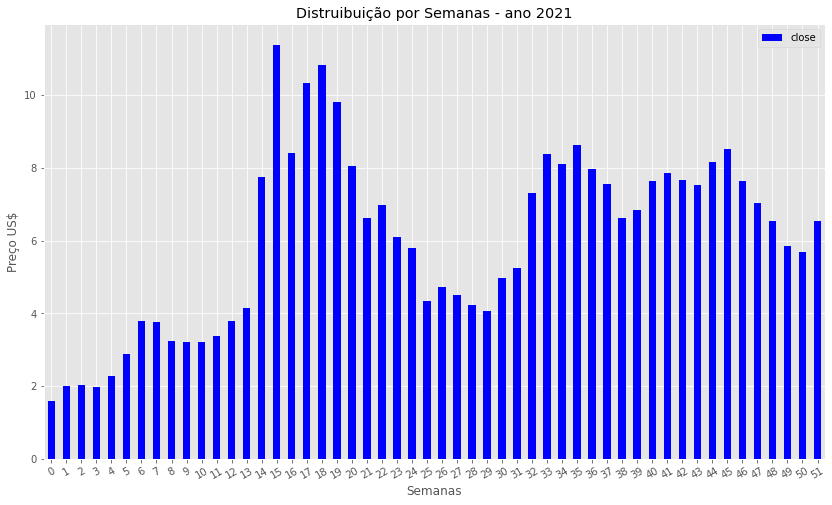

In [15]:
create_plot_custom("W", 2021, "bar")

- Empurrando para frente os valores da criptomoeda

In [16]:
df_xrp['close'] = df_xrp['close'].shift(-1)
df_xrp.tail()

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1813,2022-10-27,0.469395,0.480456,0.460977,0.462407,0.473981,1694861069,0.463250,0.478880
1814,2022-10-28,0.462427,0.474674,0.457785,0.473981,0.470416,1201992237,0.465090,0.476771
1815,2022-10-29,0.473984,0.481666,0.467697,0.470416,0.458455,1404785407,0.465797,0.474547
1816,2022-10-30,0.470407,0.472510,0.455642,0.458455,0.465915,964813817,0.464286,0.470947
1817,2022-10-31,0.458401,0.466114,0.449523,0.465915,NaN,1462007947,0.466013,0.469466


- Remover os dados nulos

In [17]:
df_xrp.dropna(inplace=True)
df_xrp

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
20,2017-11-29,0.297867,0.297867,0.239409,0.243064,0.250878,541177984,0.254914,0.231742
21,2017-11-30,0.246433,0.261524,0.229586,0.250878,0.255699,270907008,0.256125,0.233332
22,2017-12-01,0.250352,0.258828,0.239438,0.255699,0.255492,182992000,0.257704,0.235676
23,2017-12-02,0.255656,0.259218,0.250756,0.255492,0.252558,118250000,0.258147,0.237821
24,2017-12-03,0.255530,0.263072,0.247391,0.252558,0.253571,134710000,0.258681,0.240451
...,...,...,...,...,...,...,...,...,...
1812,2022-10-26,0.461466,0.470251,0.458092,0.469376,0.462407,1440473976,0.461204,0.480346
1813,2022-10-27,0.469395,0.480456,0.460977,0.462407,0.473981,1694861069,0.463250,0.478880
1814,2022-10-28,0.462427,0.474674,0.457785,0.473981,0.470416,1201992237,0.465090,0.476771
1815,2022-10-29,0.473984,0.481666,0.467697,0.470416,0.458455,1404785407,0.465797,0.474547


- Testar se o DataFrame possui dados nulos

In [18]:
assert df_xrp.isnull().sum().sum() == 0

- Separar os dados em Treino, Teste e Validação. 

In [19]:
qtd_linhas = len(df_xrp)

qtd_linhas_treino= round(.70 * qtd_linhas)
qtd_linhas_teste= qtd_linhas - qtd_linhas_treino  
qtd_linhas_validacao = qtd_linhas -1

info = (
    f"linhas treino= 0:{qtd_linhas_treino}"
    f" linhas teste= {qtd_linhas_treino}:{qtd_linhas_treino + qtd_linhas_teste -1}"
    f" linhas validação= {qtd_linhas_validacao}"
)

info

'linhas treino= 0:1258 linhas teste= 1258:1796 linhas validação= 1796'

- Separar a **labels** que será o target a ser encontrado pelo modelo preditivo
- Separar as **features** que serão utilizadas para prever o valor final

In [20]:
features = df_xrp.drop(['timestamp', 'close'], 1)
labels = df_xrp['close']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


- Escolhendo as melhores features com Kbest

In [21]:
features_list = ('timestamp', 'open', 'high', 'low', 'volume', 'mm7d', 'mm21d')

selector = SelectKBest(score_func=f_regression, k='all').fit(features, labels)
x_new = selector.transform(features)
scores = selector.scores_

raw_pairs = zip(features_list[1:], scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()

print("Melhores features:")
print(k_best_features_final)

Melhores features:
{'volume': 72325.08424504184, 'high': 48209.26562449246, 'low': 41890.94055521483, 'open': 34438.510470113964, 'mm21d': 20993.149800623007, 'mm7d': 254.12302277313825}


- Separando as features escolhidas, com melhor pontuação

In [22]:
features = df_xrp.loc[:,['volume', 'high', 'low', 'open', 'mm21d']]
features

,volume,high,low,open,mm21d
20,541177984,0.297867,0.239409,0.297867,0.231742
21,270907008,0.261524,0.229586,0.246433,0.233332
22,182992000,0.258828,0.239438,0.250352,0.235676
23,118250000,0.259218,0.250756,0.255656,0.237821
24,134710000,0.263072,0.247391,0.255530,0.240451
...,...,...,...,...,...
1812,1440473976,0.470251,0.458092,0.461466,0.480346
1813,1694861069,0.480456,0.460977,0.469395,0.478880
1814,1201992237,0.474674,0.457785,0.462427,0.476771
1815,1404785407,0.481666,0.467697,0.473984,0.474547


- Criando Pipeline

In [23]:
pipeline_linear_regression = make_pipeline(MinMaxScaler(), LinearRegression())

- Separa os dados de treino teste e validação

In [24]:

X_train = features[:qtd_linhas_treino]
X_test = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

y_train = labels[:qtd_linhas_treino]
y_test = labels[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

1258 1258
538 538


- Treina modelo

In [25]:
pipeline_linear_regression.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('linearregression', LinearRegression())])

- Confere 

In [26]:
score_model = pipeline_linear_regression.score(X_test, y_test)
f'Teste pontuação para avaliar a consistência do modelo: {score_model * 100:.2f}%'

'Teste pontuação para avaliar a consistência do modelo: 96.95%'

- Pega último dado do dataframe

In [27]:
data_pred = ['volume', 'high', 'low', 'open', 'mm21d']
df_xrp.tail(1)

,timestamp,open,high,low,Close,close,volume,mm7d,mm21d
1816,2022-10-30,0.470407,0.47251,0.455642,0.458455,0.465915,964813817,0.464286,0.470947


- Testar a predição

In [28]:
pipeline_linear_regression.predict(df_xrp.tail(1)[data_pred])

array([0.45958426])

- Realizar a predição com os dados de testes(dados que o modelo desconhece)

In [29]:
previsao = features[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

data_btc_full=df_xrp["timestamp"]
data_btc = data_btc_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]

res_full = df_xrp["close"]
res = res_full[qtd_linhas_treino:qtd_linhas_treino + qtd_linhas_teste -1]


predict2 = pipeline_linear_regression.predict(previsao)


df = pd.DataFrame({ "data_ripple": data_btc, "real": res , "previsao": predict2 })

df["real"] = df["real"].shift(+1)

df.set_index("data_ripple", inplace= True)

df.tail()



,real,previsao
data_ripple,,
2022-10-25,0.461544,0.459440
2022-10-26,0.469376,0.463282
2022-10-27,0.462407,0.469789
2022-10-28,0.473981,0.465945
2022-10-29,0.470416,0.472704


- Plotar os resultados

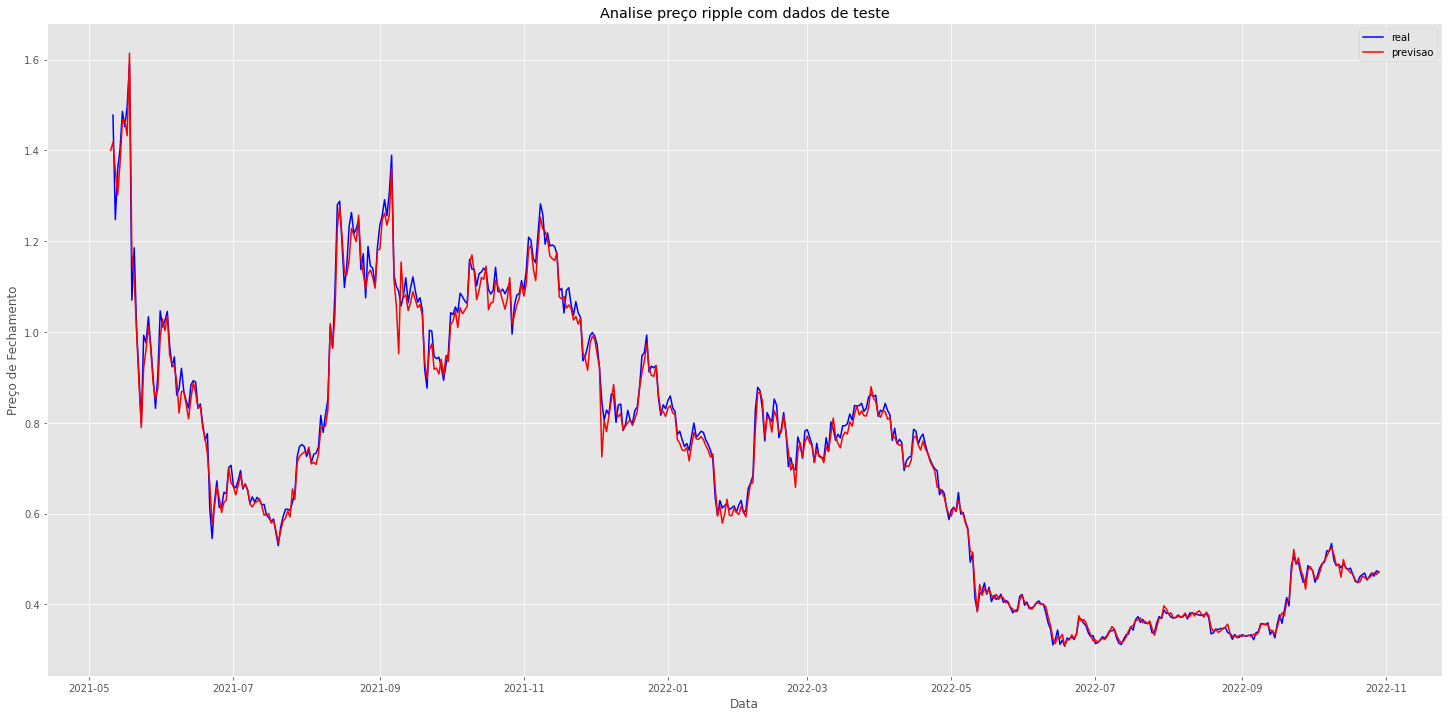

In [30]:
plt.figure(figsize=(25,12))
plt.title("Analise preço ripple com dados de teste")
plt.plot(df["real"], label="real", color="blue")
plt.plot(df["previsao"], label="previsao", color="red")
plt.xlabel("Data")
plt.ylabel("Preço de Fechamento")
leg = plt.legend()

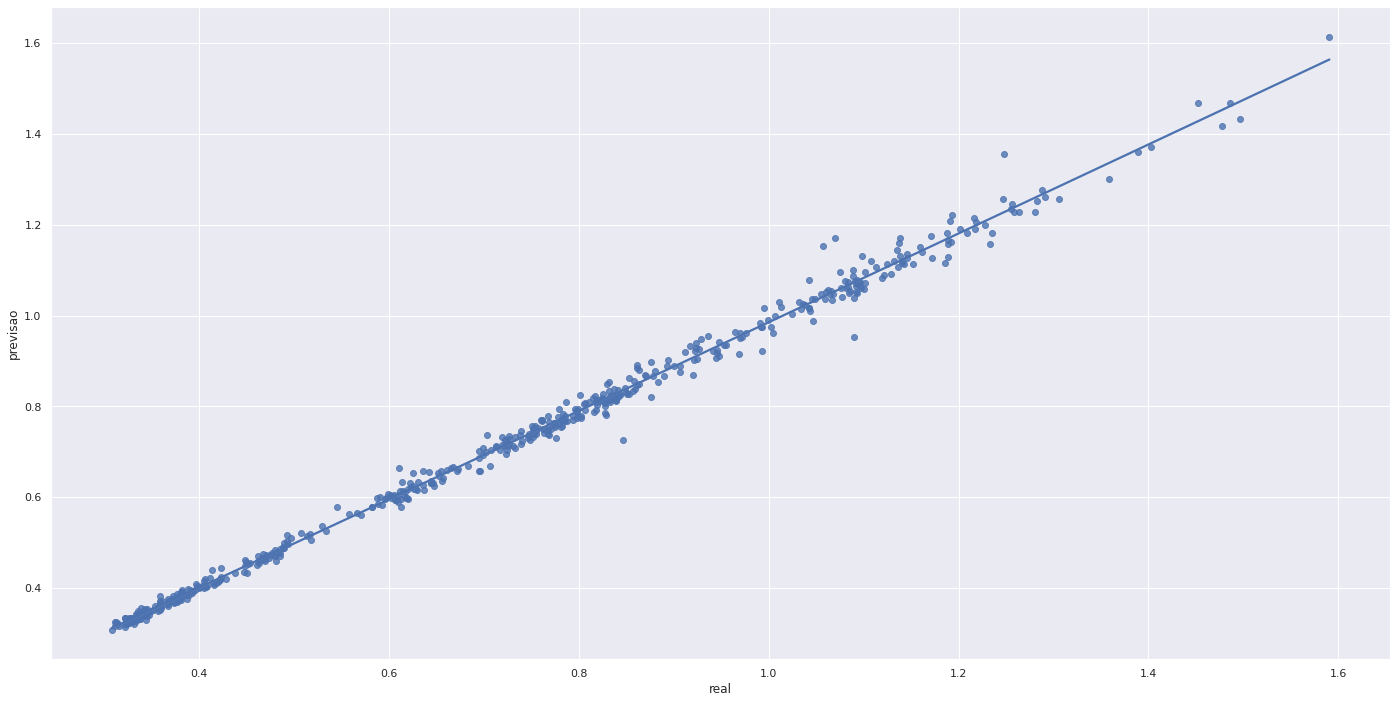

In [31]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(24, 12)})
sns.regplot(x ="real", y ="previsao", data = df, ci=False, order=2)

- Export modelo preditivo 

In [32]:
joblib.dump(pipeline_linear_regression, 'model_xrp_usd.pkl')

['model_xrp_usd.pkl']

- Import modelo preditivo

In [33]:
model = joblib.load('model_xrp_usd.pkl')